# Projet 5: Catégorisez automatiquement des questions

## Partie 2: Tests des modèles

In [1]:
#importation des librairies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
import ast
#import re
#Traitement des données
import string

#binarisation des tags
from sklearn.preprocessing import MultiLabelBinarizer

#librairies pour le tfidf - extraction d'information du texte
from sklearn.feature_extraction.text import TfidfVectorizer

#Pour LDA
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis.sklearn

#pour NMF
from sklearn.decomposition import NMF

#pour les modèles supervisés
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier

#Pour les metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from functools import partial


C:\Users\alice\Anaconda3\lib\site-packages\past\types\oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
C:\Users\alice\Anaconda3\lib\site-packages\past\builtins\misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping


In [2]:
#importation du dataset
df = pd.read_csv('clean_dataframe_final.csv')

In [3]:
df.shape

(38393, 5)

In [4]:
df.head()

,Text,TagsTokens,text_lemmatized,text_stemm_porter,text_stemm_lancaster
0,c# 50 await keyword listed operator rather mod...,['c#'],"['c#', '50', 'await', 'keyword', 'listed', 'op...","['c#', '50', 'await', 'keyword', 'list', 'oper...","['c#', '50', 'await', 'keyword', 'list', 'op',..."
1,configure mercurial use winmerge merges cygwin...,['mercurial'],"['configure', 'mercurial', 'use', 'winmerge', ...","['configur', 'mercuri', 'use', 'winmerg', 'mer...","['config', 'merc', 'us', 'winmerg', 'merg', 'c..."
2,whats best way go photoshop mockup semantic ht...,"['html', 'css']","['whats', 'best', 'way', 'go', 'photoshop', 'm...","['what', 'best', 'way', 'go', 'photoshop', 'mo...","['what', 'best', 'way', 'go', 'photoshop', 'mo..."
3,lookup data book barcode number building world...,['language-agnostic'],"['lookup', 'data', 'book', 'barcode', 'number'...","['lookup', 'data', 'book', 'barcod', 'number',...","['lookup', 'dat', 'book', 'barcod', 'numb', 'b..."
4,embeddable webkit component windows c# develop...,"['.net', 'com']","['embeddable', 'webkit', 'component', 'window'...","['embedd', 'webkit', 'compon', 'window', 'c#',...","['embed', 'webkit', 'compon', 'window', 'c#', ..."


In [5]:
df['TagsTokens']

0                            ['c#']
1                     ['mercurial']
2                   ['html', 'css']
3             ['language-agnostic']
4                   ['.net', 'com']
                    ...            
38388              ['php', 'mysql']
38389               ['html', 'css']
38390    ['c#', '.net', 'generics']
38391               ['html', 'xml']
38392                    ['winapi']
Name: TagsTokens, Length: 38393, dtype: object

## 1. Tests  sur données avec lemmatisation

### 1.1 Préparation des données

#### 1.1.1 Construction du dataset

In [6]:
#construction du dataset
cols = ['TagsTokens','text_lemmatized']
df_lemm = df[cols]

In [7]:
df_lemm.shape

(38393, 2)

In [8]:
df_lemm

,TagsTokens,text_lemmatized
0,['c#'],"['c#', '50', 'await', 'keyword', 'listed', 'op..."
1,['mercurial'],"['configure', 'mercurial', 'use', 'winmerge', ..."
2,"['html', 'css']","['whats', 'best', 'way', 'go', 'photoshop', 'm..."
3,['language-agnostic'],"['lookup', 'data', 'book', 'barcode', 'number'..."
4,"['.net', 'com']","['embeddable', 'webkit', 'component', 'window'..."
...,...,...
38388,"['php', 'mysql']","['php', 'date', 'issue', 'daylight', 'saving',..."
38389,"['html', 'css']","['attach', 'image', 'bottom', 'middle', 'tryin..."
38390,"['c#', '.net', 'generics']","['c#', 'cant', 'liststring', 'object', 'stored..."
38391,"['html', 'xml']","['way', 'comment', 'code', 'notepad2', 'notepa..."


#### 1.1.2 Préparation Train/Tests datasets

In [9]:
def removestring(text):
    return ast.literal_eval(text)

df_lemm['TagsTokens'] = df_lemm['TagsTokens'].apply(removestring)

C:\Users\alice\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [10]:
dfnew = df_lemm.copy()

In [11]:
mlb = MultiLabelBinarizer()
ytags = mlb.fit_transform(dfnew['TagsTokens'])

In [12]:
ytags #check de la binarisation

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]])

In [13]:
X_train, X_test, y_train, y_test = train_test_split(dfnew['text_lemmatized'], ytags, test_size=0.2,train_size=0.8, random_state=7)

mlb.inverse_transform(y_train)

### 1.2 Extraction de l'information du texte: tf-idf

#### 1.2.1 tf-idf sur les données train

In [14]:
#initislisation du vectorizer
tfidf_vectorizer = TfidfVectorizer(use_idf = True, max_features = 1000)
#transformation des données
X_tfidf_train = tfidf_vectorizer.fit_transform(X_train)

In [15]:
X_tfidf_train

<30714x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 956361 stored elements in Compressed Sparse Row format>

In [16]:
# récupération du premier vecteur
first_vector_tfidfvectorizer_train = X_tfidf_train[0]

In [17]:
# placement des valeurs tf-idf values dans un pandas data frame
df_lemm_tfidfd_train = pd.DataFrame(first_vector_tfidfvectorizer_train.T.todense(), 
                                    index = tfidf_vectorizer.get_feature_names(), columns = ["tfidf"])
df_lemm_tfidfd_train.sort_values(by = ["tfidf"],ascending=False)

,tfidf
map,0.717726
collection,0.404702
easy,0.261893
value,0.171563
make,0.169668
...,...
failed,0.000000
fails,0.000000
failure,0.000000
fairly,0.000000


In [18]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()


#### 1.2.2 tf-idf sur les données test

In [19]:
#initislisation du vectorizer
tfidf_vectorizer = TfidfVectorizer(use_idf = True, max_features = 1000)
#transformation des données
X_tfidf_test= tfidf_vectorizer.fit_transform(X_test)

In [20]:
X_tfidf_test

<7679x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 239032 stored elements in Compressed Sparse Row format>

In [21]:
# récupération du premier vecteur
first_vector_tfidfvectorizer_test=X_tfidf_test[0]

In [22]:
# placement des valeurs tf-idf values dans un pandas data frame
df_lemm_tfidfd_test = pd.DataFrame(first_vector_tfidfvectorizer_test.T.todense(), 
                                   index = tfidf_vectorizer.get_feature_names(), columns = ["tfidf"])
df_lemm_tfidfd_test.sort_values(by = ["tfidf"],ascending=False)

,tfidf
dialog,0.449423
assembly,0.404126
framework,0.351412
reference,0.330897
net,0.303273
...,...
fact,0.000000
factory,0.000000
fail,0.000000
failed,0.000000


### 1.3 Méthode 1: Approche non supervisée

#### 1.3.1 Latent Dirichlet Allocation (méthode non-supervisée)  -  train dataset

In [23]:
n_topics = 10

# Créer le modèle LDA
lda_model = LatentDirichletAllocation(
        n_components =n_topics, 
        max_iter = 5, 
        learning_method ='online', 
        learning_offset = 50,
        random_state = 0)

# Fitter sur les données
lda_model.fit(X_tfidf_train)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=50,
                          max_doc_update_iter=100, max_iter=5,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [24]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, X_tfidf_train, tfidf_vectorizer, mds='tsne')
panel

C:\Users\alice\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
6     -96.589386  24.950237       1        1  24.103635
9      88.614677  17.021690       2        1  15.568372
7     -13.801842 -33.460793       3        1  15.040158
1     -11.249109 -95.517563       4        1  11.728240
3      31.267065  77.249123       5        1  10.922412
2     -77.720375 -45.640770       6        1   8.958103
0      26.660820  12.413454       7        1   6.185290
5     -33.339455  24.555094       8        1   2.628912
8      54.342808 -53.057274       9        1   2.596865
4     -41.044472  87.354141      10        1   2.268014, topic_info=    Category        Freq       Term       Total  loglift  logprob
830  Default  673.000000      speed  673.000000  30.0000  30.0000
225  Default  594.000000   database  594.000000  29.0000  29.0000
871  Default  702.000000        tab  702.000000  28.0000  28.0000
373  Default  542.000000     format  542.000000  27.0000  27.0000
783  Default  661.000000     server  661.000000  26.0000  26.0000
..       ...         ...        ...         ...      ...      ...
230  Topic10    0.380729       deal   54.193637  -1.1720  -8.9804
700  Topic10    0.380807      quite   56.472386  -1.2129  -8.9802
882  Topic10    0.388704       test  117.604733  -1.9260  -8.9597
249  Topic10    0.382514     detail   82.673702  -1.5896  -8.9757
185  Topic10    0.381164  condition   78.491468  -1.5413  -8.9792

[506 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
7         1  0.439909     18
7         2  0.135357     18
7         3  0.033839     18
7         4  0.304552     18
7         7  0.033839     18
...     ...       ...    ...
995       4  0.085987    xml
995       7  0.737035    xml
996       1  0.064618  xmlns
996       3  0.096927  xmlns
996       4  0.807728  xmlns

[1936 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 10, 8, 2, 4, 3, 1, 6, 9, 5])

#### 1.3.2 Negative Matrix Factorisation (NMF) - train dataset

In [25]:
n_topics = 10
n_top_words = 10


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()


nmf = NMF(n_components = n_topics, random_state = 0, alpha = 0.1, l1_ratio = 0.5).fit(X_tfidf_train)

print("Topics found via NMF:")
print_top_words(nmf, tfidf_feature_names, n_top_words)

Topics found via NMF:

Topic #0:
window application use code way one time java net app

Topic #1:
function var return value array javascript call foo code error

Topic #2:
table sql query column database select row data value server

Topic #3:
image page text html script javascript cs button jquery content

Topic #4:
file directory path line folder script xml command source error

Topic #5:
class public object method new property void type int private

Topic #6:
string list value character new array name return public convert

Topic #7:
service server web request aspnet error http client user application

Topic #8:
test unit run testing mock running code build fail output

Topic #9:
visual studio project build 2008 2010 assembly solution version error



### 1.4 Méthode 2: Approche purement supervisée

In [26]:
def train_classifier(X_train, y_train, X_valid=None, y_valid=None, C=1.0, model='lr'):
    """
      X_train, y_train — training data
      
      return: trained classifier
      
    """
    
    if model=='lr':
        model = LogisticRegression(C=C, penalty='l1', dual=False, solver='liblinear')
        model = OneVsRestClassifier(model)
        model.fit(X_train, y_train)
    
    elif model=='svm':
        model = LinearSVC(C=C, penalty='l1', dual=False, loss='squared_hinge')
        model = OneVsRestClassifier(model)
        model.fit(X_train, y_train)
    
    elif model=='nbayes':
        model = MultinomialNB(alpha=1)
        model = OneVsRestClassifier(model)
        model.fit(X_train, y_train)
        
    elif model=='mlp':
        model = MLPClassifier()
        model = OneVsRestClassifier(model)
        model.fit(X_train, y_train)

    return model


#### 1.4.1 Réression logistique

In [27]:
%time classifier_tfidf = train_classifier(X_tfidf_train, y_train, C=1.5, model='lr')

Wall time: 27.2 s


In [28]:
y_test_predicted_labels_tfidf = classifier_tfidf.predict(X_tfidf_test)

In [29]:
y_test_pred_inversed = mlb.inverse_transform(y_test_predicted_labels_tfidf)
y_test_inversed = mlb.inverse_transform(y_test)
for i in range(20):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_test.iloc[i],
        ','.join(y_test_inversed[i]),
        ','.join(y_test_pred_inversed[i])
    ))

Title:	['assembly', 'add', 'reference', 'dialog', 'differ', 'depending', 'net', 'framework', 'used', 'curious', 'listing', 'assembly', 'add', 'reference', 'dialog', 'vary', 'depending', 'version', 'net', 'framework', 'used', 'selected', 'project', 'differ', 'love', 'difference', 'lie', 'thanks']
True labels:	.net,c#,visual-studio
Predicted labels:	


Title:	['check', 'socket', 'still', 'open', 'c++', 'app', 'us', 'standard', 'socket', 'call', 'want', 'tell', 'socket', 'still', 'open', 'without', 'sending', 'receiving', 'data', 'reliable', 'select', 'ioctlsocket', 'call', 'make']
True labels:	c++
Predicted labels:	


Title:	['array', 'case', '5', '5', 'joel', 'point', 'stack', 'overflow', 'podcast', '#', '34', 'c', 'programming', 'language', 'aka', 'k', 'r', 'mention', 'property', 'array', 'c', '5', '5', 'joel', 'say', 'pointer', 'arithmetic', 'still', 'understand', '5', '5']
True labels:	arrays
Predicted labels:	


Title:	['class', 'net', 'application', 'internal', 'note', 'application

In [30]:
def print_evaluation_scores(y_val, predicted):
    f1_score_weighted = partial(f1_score,average="weighted")
    scores = [accuracy_score, f1_score_weighted]
    for score in scores:
        print(score,score(y_val,predicted))

print('Tfidf')
print_evaluation_scores(y_test, y_test_predicted_labels_tfidf)

Tfidf
<function accuracy_score at 0x00000281C4BE1B88> 0.023831228024482353
functools.partial(<function f1_score at 0x00000281C4BE7048>, average='weighted') 0.0646448370159206


C:\Users\alice\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


C:\Users\alice\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\alice\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\alice\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\alice\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\alice\Anaconda3\lib\site-packages\sklearn\metrics\c

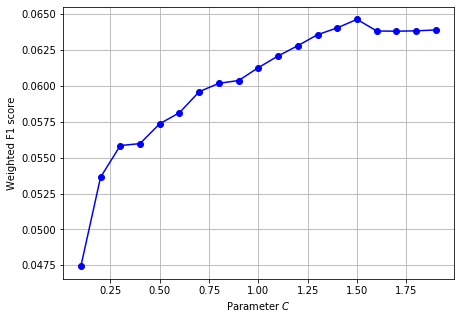

In [31]:
hypers = np.arange(0.1, 2, 0.1) #Différentes valeurs de C
res = []

for h in hypers:
    temp_model = train_classifier(X_tfidf_train, y_train, C=h, model='lr')
    temp_pred = f1_score(y_test, temp_model.predict(X_tfidf_test), average='weighted')
    res.append(temp_pred)

plt.figure(figsize=(7,5))
plt.plot(hypers, res, color='blue', marker='o')
plt.grid(True)
plt.xlabel('Parameter $C$')
plt.ylabel('Weighted F1 score')
plt.show()

#### 1.4.2 SVM

In [32]:
%time classifier_tfidf = train_classifier(X_tfidf_train, y_train, C=1.0, model='svm')

Wall time: 2min 3s


In [33]:
y_test_predicted_labels_tfidf = classifier_tfidf.predict(X_tfidf_test)

In [34]:
y_test_pred_inversed = mlb.inverse_transform(y_test_predicted_labels_tfidf)
y_test_inversed = mlb.inverse_transform(y_test)
for i in range(20):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_test.iloc[i],
        ','.join(y_test_inversed[i]),
        ','.join(y_test_pred_inversed[i])
    ))

Title:	['assembly', 'add', 'reference', 'dialog', 'differ', 'depending', 'net', 'framework', 'used', 'curious', 'listing', 'assembly', 'add', 'reference', 'dialog', 'vary', 'depending', 'version', 'net', 'framework', 'used', 'selected', 'project', 'differ', 'love', 'difference', 'lie', 'thanks']
True labels:	.net,c#,visual-studio
Predicted labels:	


Title:	['check', 'socket', 'still', 'open', 'c++', 'app', 'us', 'standard', 'socket', 'call', 'want', 'tell', 'socket', 'still', 'open', 'without', 'sending', 'receiving', 'data', 'reliable', 'select', 'ioctlsocket', 'call', 'make']
True labels:	c++
Predicted labels:	


Title:	['array', 'case', '5', '5', 'joel', 'point', 'stack', 'overflow', 'podcast', '#', '34', 'c', 'programming', 'language', 'aka', 'k', 'r', 'mention', 'property', 'array', 'c', '5', '5', 'joel', 'say', 'pointer', 'arithmetic', 'still', 'understand', '5', '5']
True labels:	arrays
Predicted labels:	


Title:	['class', 'net', 'application', 'internal', 'note', 'application

In [35]:
def print_evaluation_scores(y_val, predicted):
    f1_score_weighted = partial(f1_score,average="weighted")
    scores = [accuracy_score, f1_score_weighted]
    for score in scores:
        print(score,score(y_val,predicted))

print('Tfidf')
print_evaluation_scores(y_test, y_test_predicted_labels_tfidf)

Tfidf
<function accuracy_score at 0x00000281C4BE1B88> 0.023310326865477276
functools.partial(<function f1_score at 0x00000281C4BE7048>, average='weighted') 0.06594580816210109


C:\Users\alice\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### 1.4.3 Naive Bayes

In [36]:
%time classifier_tfidf = train_classifier(X_tfidf_train, y_train, C=1.0, model='nbayes')

Wall time: 1.14 s


In [37]:
y_test_predicted_labels_tfidf = classifier_tfidf.predict(X_tfidf_test)

In [38]:
y_test_pred_inversed = mlb.inverse_transform(y_test_predicted_labels_tfidf)
y_test_inversed = mlb.inverse_transform(y_test)
for i in range(20):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_test.iloc[i],
        ','.join(y_test_inversed[i]),
        ','.join(y_test_pred_inversed[i])
    ))

Title:	['assembly', 'add', 'reference', 'dialog', 'differ', 'depending', 'net', 'framework', 'used', 'curious', 'listing', 'assembly', 'add', 'reference', 'dialog', 'vary', 'depending', 'version', 'net', 'framework', 'used', 'selected', 'project', 'differ', 'love', 'difference', 'lie', 'thanks']
True labels:	.net,c#,visual-studio
Predicted labels:	


Title:	['check', 'socket', 'still', 'open', 'c++', 'app', 'us', 'standard', 'socket', 'call', 'want', 'tell', 'socket', 'still', 'open', 'without', 'sending', 'receiving', 'data', 'reliable', 'select', 'ioctlsocket', 'call', 'make']
True labels:	c++
Predicted labels:	


Title:	['array', 'case', '5', '5', 'joel', 'point', 'stack', 'overflow', 'podcast', '#', '34', 'c', 'programming', 'language', 'aka', 'k', 'r', 'mention', 'property', 'array', 'c', '5', '5', 'joel', 'say', 'pointer', 'arithmetic', 'still', 'understand', '5', '5']
True labels:	arrays
Predicted labels:	


Title:	['class', 'net', 'application', 'internal', 'note', 'application

In [39]:
def print_evaluation_scores(y_val, predicted):
    f1_score_weighted = partial(f1_score,average="weighted")
    scores = [accuracy_score, f1_score_weighted]
    for score in scores:
        print(score,score(y_val,predicted))

print('Tfidf')
print_evaluation_scores(y_test, y_test_predicted_labels_tfidf)

Tfidf
<function accuracy_score at 0x00000281C4BE1B88> 0.0024742805052741243
functools.partial(<function f1_score at 0x00000281C4BE7048>, average='weighted') 0.004598291732908466


C:\Users\alice\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### 1.4.4 Multi-Layered Preceptron - Neural Networks

In [40]:
%time classifier_tfidf = train_classifier(X_tfidf_train, y_train, C=1.0, model='mlp')

Wall time: 51min 50s


In [41]:
y_test_predicted_labels_tfidf = classifier_tfidf.predict(X_tfidf_test)

In [42]:
y_test_pred_inversed = mlb.inverse_transform(y_test_predicted_labels_tfidf)
y_test_inversed = mlb.inverse_transform(y_test)
for i in range(20):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_test.iloc[i],
        ','.join(y_test_inversed[i]),
        ','.join(y_test_pred_inversed[i])
    ))

Title:	['assembly', 'add', 'reference', 'dialog', 'differ', 'depending', 'net', 'framework', 'used', 'curious', 'listing', 'assembly', 'add', 'reference', 'dialog', 'vary', 'depending', 'version', 'net', 'framework', 'used', 'selected', 'project', 'differ', 'love', 'difference', 'lie', 'thanks']
True labels:	.net,c#,visual-studio
Predicted labels:	


Title:	['check', 'socket', 'still', 'open', 'c++', 'app', 'us', 'standard', 'socket', 'call', 'want', 'tell', 'socket', 'still', 'open', 'without', 'sending', 'receiving', 'data', 'reliable', 'select', 'ioctlsocket', 'call', 'make']
True labels:	c++
Predicted labels:	


Title:	['array', 'case', '5', '5', 'joel', 'point', 'stack', 'overflow', 'podcast', '#', '34', 'c', 'programming', 'language', 'aka', 'k', 'r', 'mention', 'property', 'array', 'c', '5', '5', 'joel', 'say', 'pointer', 'arithmetic', 'still', 'understand', '5', '5']
True labels:	arrays
Predicted labels:	c#,events,iphone


Title:	['class', 'net', 'application', 'internal', 'not

In [43]:
def print_evaluation_scores(y_val, predicted):
    f1_score_weighted = partial(f1_score,average="weighted")
    scores = [accuracy_score, f1_score_weighted]
    for score in scores:
        print(score,score(y_val,predicted))

print('Tfidf')
print_evaluation_scores(y_test, y_test_predicted_labels_tfidf)

Tfidf
<function accuracy_score at 0x00000281C4BE1B88> 0.023180101575726007
functools.partial(<function f1_score at 0x00000281C4BE7048>, average='weighted') 0.07167811197212086


C:\Users\alice\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## 2. Tests  sur données avec Stemming Porter

### 2.1 Préparation des données

#### 2.1.1 Construction du dataset

In [44]:
#construction du dataset
cols = ['TagsTokens','text_stemm_porter']
df_lemm = df[cols]

In [45]:
df_lemm.shape

(38393, 2)

In [46]:
df_lemm

,TagsTokens,text_stemm_porter
0,['c#'],"['c#', '50', 'await', 'keyword', 'list', 'oper..."
1,['mercurial'],"['configur', 'mercuri', 'use', 'winmerg', 'mer..."
2,"['html', 'css']","['what', 'best', 'way', 'go', 'photoshop', 'mo..."
3,['language-agnostic'],"['lookup', 'data', 'book', 'barcod', 'number',..."
4,"['.net', 'com']","['embedd', 'webkit', 'compon', 'window', 'c#',..."
...,...,...
38388,"['php', 'mysql']","['php', 'date', 'issu', 'daylight', 'save', 's..."
38389,"['html', 'css']","['attach', 'imag', 'bottom', 'middl', 'tri', '..."
38390,"['c#', '.net', 'generics']","['c#', 'cant', 'liststr', 'object', 'store', '..."
38391,"['html', 'xml']","['way', 'comment', 'code', 'notepad2', 'notepa..."


#### 2.1.2 Préparation Train/Tests datasets

In [47]:
def removestring(text):
    return ast.literal_eval(text)

df_lemm['TagsTokens'] = df_lemm['TagsTokens'].apply(removestring)

C:\Users\alice\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [48]:
dfnew = df_lemm.copy()

In [49]:
mlb = MultiLabelBinarizer()
ytags = mlb.fit_transform(dfnew['TagsTokens'])

In [50]:
ytags #check de la binarisation

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]])

In [51]:
X_train, X_test, y_train, y_test = train_test_split(dfnew['text_stemm_porter'], ytags, test_size=0.2,train_size=0.8, random_state=7)

### 2.2 Extraction de l'information du texte: tf-idf

#### 2.2.1 tf-idf sur les données train

In [52]:
#initislisation du vectorizer
tfidf_vectorizer = TfidfVectorizer(use_idf = True, max_features = 1000)
#transformation des données
X_tfidf_train = tfidf_vectorizer.fit_transform(X_train)

In [53]:
X_tfidf_train

<30714x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 1031793 stored elements in Compressed Sparse Row format>

In [54]:
# récupération du premier vecteur
first_vector_tfidfvectorizer_train = X_tfidf_train[0]

In [55]:
# placement des valeurs tf-idf values dans un pandas data frame
df_lemm_tfidfd_train = pd.DataFrame(first_vector_tfidfvectorizer_train.T.todense(), 
                                    index = tfidf_vectorizer.get_feature_names(), columns = ["tfidf"])
df_lemm_tfidfd_train.sort_values(by = ["tfidf"],ascending=False)

,tfidf
map,0.697316
collect,0.416331
easi,0.277748
valu,0.181880
make,0.173360
...,...
fals,0.000000
far,0.000000
featur,0.000000
feel,0.000000


In [56]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()


#### 2.2.2 tf-idf sur les données test

In [57]:
#initislisation du vectorizer
tfidf_vectorizer = TfidfVectorizer(use_idf = True, max_features = 1000)
#transformation des données
X_tfidf_test= tfidf_vectorizer.fit_transform(X_test)

In [58]:
X_tfidf_test

<7679x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 258091 stored elements in Compressed Sparse Row format>

In [59]:
# récupération du premier vecteur
first_vector_tfidfvectorizer_test=X_tfidf_test[0]

In [60]:
# placement des valeurs tf-idf values dans un pandas data frame
df_lemm_tfidfd_test = pd.DataFrame(first_vector_tfidfvectorizer_test.T.todense(), 
                                   index = tfidf_vectorizer.get_feature_names(), columns = ["tfidf"])
df_lemm_tfidfd_test.sort_values(by = ["tfidf"],ascending=False)

,tfidf
dialog,0.415007
assembl,0.370170
differ,0.366964
framework,0.324501
depend,0.321953
...,...
feel,0.000000
field,0.000000
figur,0.000000
file,0.000000


### 2.3 Méthode 1: Approche non supervisée

#### 2.3.1 Latent Dirichlet Allocation (méthode non-supervisée)  -  train dataset

In [61]:
n_topics = 10

# Créer le modèle LDA
lda_model = LatentDirichletAllocation(
        n_components =n_topics, 
        max_iter = 5, 
        learning_method ='online', 
        learning_offset = 50,
        random_state = 0)

# Fitter sur les données
lda_model.fit(X_tfidf_train)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=50,
                          max_doc_update_iter=100, max_iter=5,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [62]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, X_tfidf_train, tfidf_vectorizer, mds='tsne')
panel

C:\Users\alice\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
5      -31.156677   99.480705       1        1  16.303564
9       89.144585 -105.970161       2        1  15.102301
7      144.234436  -16.160231       3        1  13.184089
0      -87.515778 -176.816177       4        1  13.071892
2      -91.983498   13.456775       5        1  11.473479
3       25.143873   -5.964596       6        1  10.593891
8       28.302696 -191.987305       7        1   9.394845
6       84.660866   84.314232       8        1   5.800662
1     -147.086243  -76.341660       9        1   2.773717
4      -27.987614  -86.545166      10        1   2.301558, topic_info=    Category        Freq     Term       Total  loglift  logprob
848  Default  883.000000   string  883.000000  30.0000  30.0000
542  Default  373.000000      may  373.000000  29.0000  29.0000
331  Default  360.000000   extern  360.000000  28.0000  28.0000
721  Default  333.000000  reflect  333.000000  27.0000  27.0000
153  Default  378.000000  certain  378.000000  26.0000  26.0000
..       ...         ...      ...         ...      ...      ...
422  Topic10   25.602451       id  316.388765   1.2573  -4.8158
142  Topic10   19.945268     call  261.041641   1.1999  -5.0655
357  Topic10   19.251190    flash  280.355484   1.0931  -5.1009
366  Topic10   22.327614   format  411.272646   0.8582  -4.9527
319  Topic10   18.524826    exist  368.349218   0.7817  -5.1394

[529 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
10        2  0.011401  2005
10        3  0.205226  2005
10        6  0.022803  2005
10        7  0.114014  2005
10        8  0.638481  2005
...     ...       ...   ...
998       3  0.051972  year
998       4  0.025986  year
998       5  0.064965  year
998       6  0.012993  year
998       8  0.402786  year

[2388 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 10, 8, 1, 3, 4, 9, 7, 2, 5])

#### 2.3.2 Negative Matrix Factorisation (NMF) - train dataset

In [63]:
n_topics = 10
n_top_words = 10


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()


nmf = NMF(n_components = n_topics, random_state = 0, alpha = 0.1, l1_ratio = 0.5).fit(X_tfidf_train)

print("Topics found via NMF:")
print_top_words(nmf, tfidf_feature_names, n_top_words)

Topics found via NMF:

Topic #0:
applic window use app user run servic server web net

Topic #1:
class public object method properti void type new privat get

Topic #2:
tabl sql queri column databas select row data server valu

Topic #3:
page imag text html control button javascript script jqueri css

Topic #4:
file directori line path folder script upload python open xml

Topic #5:
function return valu var call foo array code int javascript

Topic #6:
string valu charact new public return convert match name regex

Topic #7:
test unit run mock fail integr code assert write expect

Topic #8:
list item object select collect array new order way element

Topic #9:
project visual studio build 2008 instal compil assembl version 2010



### 2.4 Méthode 2: Approche purement supervisée

In [64]:
def train_classifier(X_train, y_train, X_valid=None, y_valid=None, C=1.0, model='lr'):
    """
      X_train, y_train — training data
      
      return: trained classifier
      
    """
    
    if model=='lr':
        model = LogisticRegression(C=C, penalty='l1', dual=False, solver='liblinear')
        model = OneVsRestClassifier(model)
        model.fit(X_train, y_train)
    
    elif model=='svm':
        model = LinearSVC(C=C, penalty='l1', dual=False, loss='squared_hinge')
        model = OneVsRestClassifier(model)
        model.fit(X_train, y_train)
    
    elif model=='nbayes':
        model = MultinomialNB(alpha=1)
        model = OneVsRestClassifier(model)
        model.fit(X_train, y_train)
        
    elif model=='mlp':
        model = MLPClassifier()
        model = OneVsRestClassifier(model)
        model.fit(X_train, y_train)

    return model


#### 1.4.1 Réression logistique

In [65]:
%time classifier_tfidf = train_classifier(X_tfidf_train, y_train, C=1.5, model='lr')

Wall time: 29.2 s


In [66]:
y_test_predicted_labels_tfidf = classifier_tfidf.predict(X_tfidf_test)

In [67]:
y_test_pred_inversed = mlb.inverse_transform(y_test_predicted_labels_tfidf)
y_test_inversed = mlb.inverse_transform(y_test)
for i in range(20):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_test.iloc[i],
        ','.join(y_test_inversed[i]),
        ','.join(y_test_pred_inversed[i])
    ))

Title:	['assembl', 'add', 'refer', 'dialog', 'differ', 'depend', 'net', 'framework', 'use', 'curiou', 'list', 'assembl', 'add', 'refer', 'dialog', 'vari', 'depend', 'version', 'net', 'framework', 'use', 'select', 'project', 'differ', 'love', 'differ', 'lie', 'thank']
True labels:	.net,c#,visual-studio
Predicted labels:	


Title:	['check', 'socket', 'still', 'open', 'c++', 'app', 'use', 'standard', 'socket', 'call', 'want', 'tell', 'socket', 'still', 'open', 'without', 'send', 'receiv', 'data', 'reliabl', 'select', 'ioctlsocket', 'call', 'make']
True labels:	c++
Predicted labels:	


Title:	['array', 'case', '5', '5', 'joel', 'point', 'stack', 'overflow', 'podcast', '#', '34', 'c', 'program', 'languag', 'aka', 'k', 'r', 'mention', 'properti', 'array', 'c', '5', '5', 'joel', 'say', 'pointer', 'arithmet', 'still', 'understand', '5', '5']
True labels:	arrays
Predicted labels:	


Title:	['class', 'net', 'applic', 'intern', 'note', 'applic', 'oppos', 'librari', 'wpf', 'applic', 'broken', 'mai

In [68]:
def print_evaluation_scores(y_val, predicted):
    f1_score_weighted = partial(f1_score,average="weighted")
    scores = [accuracy_score, f1_score_weighted]
    for score in scores:
        print(score,score(y_val,predicted))

print('Tfidf')
print_evaluation_scores(y_test, y_test_predicted_labels_tfidf)

Tfidf
<function accuracy_score at 0x00000281C4BE1B88> 0.024352129183487434
functools.partial(<function f1_score at 0x00000281C4BE7048>, average='weighted') 0.06803333800432562


C:\Users\alice\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


C:\Users\alice\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\alice\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\alice\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\alice\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\alice\Anaconda3\lib\site-packages\sklearn\metrics\c

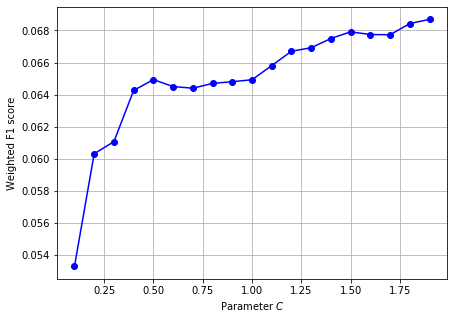

In [69]:
hypers = np.arange(0.1, 2, 0.1) #Différentes valeurs de C
res = []

for h in hypers:
    temp_model = train_classifier(X_tfidf_train, y_train, C=h, model='lr')
    temp_pred = f1_score(y_test, temp_model.predict(X_tfidf_test), average='weighted')
    res.append(temp_pred)

plt.figure(figsize=(7,5))
plt.plot(hypers, res, color='blue', marker='o')
plt.grid(True)
plt.xlabel('Parameter $C$')
plt.ylabel('Weighted F1 score')
plt.show()

#### 1.4.2 SVM

In [70]:
%time classifier_tfidf = train_classifier(X_tfidf_train, y_train, C=1.0, model='svm')

Wall time: 2min 10s


In [71]:
y_test_predicted_labels_tfidf = classifier_tfidf.predict(X_tfidf_test)

In [72]:
y_test_pred_inversed = mlb.inverse_transform(y_test_predicted_labels_tfidf)
y_test_inversed = mlb.inverse_transform(y_test)
for i in range(20):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_test.iloc[i],
        ','.join(y_test_inversed[i]),
        ','.join(y_test_pred_inversed[i])
    ))

Title:	['assembl', 'add', 'refer', 'dialog', 'differ', 'depend', 'net', 'framework', 'use', 'curiou', 'list', 'assembl', 'add', 'refer', 'dialog', 'vari', 'depend', 'version', 'net', 'framework', 'use', 'select', 'project', 'differ', 'love', 'differ', 'lie', 'thank']
True labels:	.net,c#,visual-studio
Predicted labels:	


Title:	['check', 'socket', 'still', 'open', 'c++', 'app', 'use', 'standard', 'socket', 'call', 'want', 'tell', 'socket', 'still', 'open', 'without', 'send', 'receiv', 'data', 'reliabl', 'select', 'ioctlsocket', 'call', 'make']
True labels:	c++
Predicted labels:	


Title:	['array', 'case', '5', '5', 'joel', 'point', 'stack', 'overflow', 'podcast', '#', '34', 'c', 'program', 'languag', 'aka', 'k', 'r', 'mention', 'properti', 'array', 'c', '5', '5', 'joel', 'say', 'pointer', 'arithmet', 'still', 'understand', '5', '5']
True labels:	arrays
Predicted labels:	


Title:	['class', 'net', 'applic', 'intern', 'note', 'applic', 'oppos', 'librari', 'wpf', 'applic', 'broken', 'mai

In [73]:
def print_evaluation_scores(y_val, predicted):
    f1_score_weighted = partial(f1_score,average="weighted")
    scores = [accuracy_score, f1_score_weighted]
    for score in scores:
        print(score,score(y_val,predicted))

print('Tfidf')
print_evaluation_scores(y_test, y_test_predicted_labels_tfidf)

Tfidf
<function accuracy_score at 0x00000281C4BE1B88> 0.02539393150149759
functools.partial(<function f1_score at 0x00000281C4BE7048>, average='weighted') 0.06947268604960295


C:\Users\alice\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### 1.4.3 Naive Bayes

In [74]:
%time classifier_tfidf = train_classifier(X_tfidf_train, y_train, C=1.0, model='nbayes')

Wall time: 1.26 s


In [75]:
y_test_predicted_labels_tfidf = classifier_tfidf.predict(X_tfidf_test)

In [76]:
y_test_pred_inversed = mlb.inverse_transform(y_test_predicted_labels_tfidf)
y_test_inversed = mlb.inverse_transform(y_test)
for i in range(20):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_test.iloc[i],
        ','.join(y_test_inversed[i]),
        ','.join(y_test_pred_inversed[i])
    ))

Title:	['assembl', 'add', 'refer', 'dialog', 'differ', 'depend', 'net', 'framework', 'use', 'curiou', 'list', 'assembl', 'add', 'refer', 'dialog', 'vari', 'depend', 'version', 'net', 'framework', 'use', 'select', 'project', 'differ', 'love', 'differ', 'lie', 'thank']
True labels:	.net,c#,visual-studio
Predicted labels:	


Title:	['check', 'socket', 'still', 'open', 'c++', 'app', 'use', 'standard', 'socket', 'call', 'want', 'tell', 'socket', 'still', 'open', 'without', 'send', 'receiv', 'data', 'reliabl', 'select', 'ioctlsocket', 'call', 'make']
True labels:	c++
Predicted labels:	


Title:	['array', 'case', '5', '5', 'joel', 'point', 'stack', 'overflow', 'podcast', '#', '34', 'c', 'program', 'languag', 'aka', 'k', 'r', 'mention', 'properti', 'array', 'c', '5', '5', 'joel', 'say', 'pointer', 'arithmet', 'still', 'understand', '5', '5']
True labels:	arrays
Predicted labels:	


Title:	['class', 'net', 'applic', 'intern', 'note', 'applic', 'oppos', 'librari', 'wpf', 'applic', 'broken', 'mai

In [77]:
def print_evaluation_scores(y_val, predicted):
    f1_score_weighted = partial(f1_score,average="weighted")
    scores = [accuracy_score, f1_score_weighted]
    for score in scores:
        print(score,score(y_val,predicted))

print('Tfidf')
print_evaluation_scores(y_test, y_test_predicted_labels_tfidf)

Tfidf
<function accuracy_score at 0x00000281C4BE1B88> 0.0028649563745279335
functools.partial(<function f1_score at 0x00000281C4BE7048>, average='weighted') 0.0074605728103369915


C:\Users\alice\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### 1.4.4 Multi-Layered Preceptron - Neural Networks

In [78]:
%time classifier_tfidf = train_classifier(X_tfidf_train, y_train, C=1.0, model='mlp')

Wall time: 52min 30s


In [79]:
y_test_predicted_labels_tfidf = classifier_tfidf.predict(X_tfidf_test)

In [80]:
y_test_pred_inversed = mlb.inverse_transform(y_test_predicted_labels_tfidf)
y_test_inversed = mlb.inverse_transform(y_test)
for i in range(20):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_test.iloc[i],
        ','.join(y_test_inversed[i]),
        ','.join(y_test_pred_inversed[i])
    ))

Title:	['assembl', 'add', 'refer', 'dialog', 'differ', 'depend', 'net', 'framework', 'use', 'curiou', 'list', 'assembl', 'add', 'refer', 'dialog', 'vari', 'depend', 'version', 'net', 'framework', 'use', 'select', 'project', 'differ', 'love', 'differ', 'lie', 'thank']
True labels:	.net,c#,visual-studio
Predicted labels:	c++


Title:	['check', 'socket', 'still', 'open', 'c++', 'app', 'use', 'standard', 'socket', 'call', 'want', 'tell', 'socket', 'still', 'open', 'without', 'send', 'receiv', 'data', 'reliabl', 'select', 'ioctlsocket', 'call', 'make']
True labels:	c++
Predicted labels:	ios


Title:	['array', 'case', '5', '5', 'joel', 'point', 'stack', 'overflow', 'podcast', '#', '34', 'c', 'program', 'languag', 'aka', 'k', 'r', 'mention', 'properti', 'array', 'c', '5', '5', 'joel', 'say', 'pointer', 'arithmet', 'still', 'understand', '5', '5']
True labels:	arrays
Predicted labels:	


Title:	['class', 'net', 'applic', 'intern', 'note', 'applic', 'oppos', 'librari', 'wpf', 'applic', 'broken'

In [81]:
def print_evaluation_scores(y_val, predicted):
    f1_score_weighted = partial(f1_score,average="weighted")
    scores = [accuracy_score, f1_score_weighted]
    for score in scores:
        print(score,score(y_val,predicted))

print('Tfidf')
print_evaluation_scores(y_test, y_test_predicted_labels_tfidf)

Tfidf
<function accuracy_score at 0x00000281C4BE1B88> 0.024352129183487434
functools.partial(<function f1_score at 0x00000281C4BE7048>, average='weighted') 0.07033063623963018


C:\Users\alice\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
